In [1]:
from neural_nets import *
from torch.autograd import Variable
from util import *

import aesmc.inference
import aesmc.state as st
import aesmc.util
import aesmc.wakesleep
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.switch_backend('agg')

% matplotlib inline

In [5]:
def get_posterior(
    hmm_initial, hmm_transition, hmm_emission, hmm_proposal, test_num_particles, test_algorithm, observations
):
    hmm_initial.batch_size = 1
    hmm_initial.num_particles = test_num_particles
    hmm_transition.batch_size = 1
    hmm_transition.num_particles = test_num_particles
    hmm_emission.batch_size = 1
    hmm_emission.num_particles = test_num_particles
    hmm_proposal.batch_size = 1
    hmm_proposal.num_particles = test_num_particles
    
    test_observation_states = [st.State(
        batch_size=1,
        num_particles=test_num_particles,
        values={
            'y': Variable(torch.Tensor([observation]).unsqueeze(0).expand(1, test_num_particles))
        }
    ) for observation in test_data]
    inference_result = aesmc.inference.infer(
        test_algorithm,
        test_observation_states,
        hmm_initial,
        hmm_transition,
        hmm_emission,
        hmm_proposal,
        test_num_particles
    )
    
    # latent states
    latent_states = np.array([
        latent_state.x.data.numpy().flatten() for latent_state in inference_result.latent_states
    ]).transpose()
    num_particles, num_timesteps = latent_states.shape

    # weights
    unnormalized_log_weights = inference_result.log_weight.data.numpy().flatten()
    normalized_log_weights = unnormalized_log_weights - \
        sp.special.logsumexp(unnormalized_log_weights)
    normalized_weights = np.exp(normalized_log_weights)
    normalized_weights_duplicated = np.tile(
        np.reshape(normalized_weights, (-1, 1)), reps=(1, num_timesteps)
    )

    posterior = np.zeros((num_states, num_timesteps))
    for state in range(num_states):
        posterior[state] = np.sum(
            normalized_weights_duplicated * (latent_states == state), axis=0
        )

    return posterior


def get_true_posterior(initial_probs, transition_probs, obs_means, obs_vars, observations):
    my_hmm = make_hmm(initial_probs, transition_probs, obs_means, obs_vars)
    return my_hmm.predict_proba(np.reshape(observations, (-1, 1))).transpose()


def get_sum_kl(posterior_1, posterior_2, epsilon=1e-10):
    return np.sum(
        posterior_1 * (
            np.log(posterior_1 + epsilon) - np.log(posterior_2 + epsilon)
        )
    )


def get_sum_l2(posterior_1, posterior_2):
    return np.sum(np.sqrt(np.sum((posterior_1 - posterior_2)**2, axis=0)))

In [6]:
algorithm = 'is'
num_particles = 20

initial_probs, true_transition_probs, obs_means, obs_vars = \
    read_model('model.csv')
num_states = len(initial_probs)

hmm_initial = HMMInitialDistribution(initial_probs)
hmm_transition = HMMTransitionNetwork(num_states)
hmm_emission = HMMEmissionDistribution(obs_means, obs_vars)
hmm_proposal = HMMProposalNetwork(num_states)

hmm_wakesleep = aesmc.wakesleep.WakeSleep(
    hmm_initial, hmm_transition, hmm_emission, hmm_proposal
)
hmm_wakesleep.load_state_dict(torch.load(
    '{}_{}_hmm_wakesleep.pt'.format(algorithm, num_particles),
    map_location=lambda storage, loc: storage
))

test_data = np.genfromtxt('test_data.csv', delimiter=',')
test_algorithm = 'is'
test_num_particles = 50

true_posterior = get_true_posterior(initial_probs, true_transition_probs, obs_means, obs_vars, test_data)
posterior = get_posterior(hmm_initial, hmm_transition, hmm_emission, hmm_proposal, test_num_particles, test_algorithm, test_data)

/Users/tuananhle/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tuananhle/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function logsumexp is deprecated; sklearn.utils.extmath.logsumexp was deprecated in version 0.19 and will be removed in 0.21. Use scipy.misc.logsumexp instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tuananhle/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function logsumexp is deprecated; sklearn.utils.extmath.logsumexp was deprecated in version 0.19 and will be removed in 0.21. Use scipy.misc.logsumexp instead.
  warnings.warn(msg, category=DeprecationWarning)


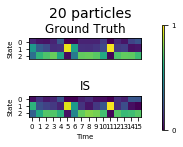

In [7]:
fig = plt.figure()
fig.set_size_inches(3.25, 2)
fig.suptitle('{} particle{}'.format(
    num_particles, '' if num_particles == 1 else 's'
), fontsize=14, x=0.4, horizontalalignment='center')

gs = matplotlib.gridspec.GridSpec(2, 2)
axs = [plt.subplot(gs[i, :-1])
       for i in range(2)]
colorbar_ax = plt.subplot(gs[:, -1], aspect=50)

temp = axs[0].imshow(
    true_posterior, clim=[0, 1]
)
axs[0].grid(False)
axs[0].set_ylabel('State')
axs[0].set_title('Ground Truth', fontsize=12)
axs[0].set_xticks([])
axs[0].set_yticks(range(num_states))

for ax, algorithm in zip(axs[1:], ['is']):
    temp = ax.imshow(
        posterior,
        clim=[0, 1]
    )
    ax.grid(False)
    ax.set_ylabel('State')
    ax.set_title(algorithm.upper(), fontsize=12)
    ax.set_xticks([])
    ax.set_yticks(range(num_states))

axs[-1].set_xticks(np.arange(16))
axs[-1].set_xlabel('Time')
fig.colorbar(
    temp, cax=colorbar_ax, orientation='vertical', ticks=[0, 1]
)

fig.tight_layout()
gs.tight_layout(fig, rect=[0, 0, 1, 0.95])

In [8]:
get_sum_l2(true_posterior, posterior)

1.1854882127030846

In [9]:
get_sum_kl(true_posterior, posterior)

0.52591879610974157